# Monte Carlo Simulation of Scintillator and PMT for AESOP-Lite

### By Liam Branch and Robert Johnson

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import random

### Links
- [Simple ray tracing](https://medium.com/swlh/ray-tracing-from-scratch-in-python-41670e6a96f9)
-[2D intersection circle](https://www.geometrictools.com/Documentation/IntersectionLine2Circle2.pdf)
- [3D intersection sphere](https://math.stackexchange.com/questions/2247498/intersection-of-ray-with-circle-in-3d-subject-to-endpoint-and-orientation-constr)
- [3D ray sphere v2](https://math.stackexchange.com/questions/70196/whats-the-distance-between-a-ray-and-a-sphere)
- [Chords on a circle](https://en.wikipedia.org/wiki/Chord_(geometry))
- [Fresnel equations](https://en.wikipedia.org/wiki/Fresnel_equations)

PDF Datasheets
- [Hamamatasu](hamamatsu.com/content/dam/hamamatsu-photonics/sites/documents/99_SALES_LIBRARY/etd/R2083_R3377_TPMH1227E.pdf)

In [2]:
# Constants
c = 0.0299792 # Speed of Light in cm / ps

In [3]:
scint_radius = 13. # cm
scint_width = 0.5
width_pmt_window = 4 # cm
length_pmt_window = 1 #cm
width = width_pmt_window/2
length = length_pmt_window
theta_lim = np.arcsin(width/scint_radius)
# Position of PMT
x = width/np.tan(theta_lim) # thetax_0
y = -width
# Main Scintillator angles
theta_scint = np.linspace(theta_lim,2*np.pi-theta_lim, 100)

In [42]:
# def distance_solver(u, o, center, radius):
#     print("v",u,"CP",o,"radius",radius)
#     CP = center-o
#     OC = center # - (0,0)
#     u = u*-1 if np.dot(u,CP) < 0 else u # make sure vectors v and OP are in same half space\
#     n = np.cross(u, CP) #axisc=2)                 # orthogonal with plane of intersection points and line passing through center
#     print(CP,u, "n",n)
#     perp = normalize(np.cross(u, n)) if np.array(n).ndim > 2 else normalize(u*n)    # perp is parallel to line of intersection and orthogonal to v and n
#     Q2P = OC-radius*perp
#     cosalpha = np.dot(perp, normalize(Q2P))
#     rootA = -np.sqrt(np.sum((radius*perp + (radius/cosalpha)*normalize(Q2P))**2))
#     rootB = np.sqrt(np.sum((radius*perp + (radius/cosalpha)*normalize(Q2P))**2))
#     return -rootA if (rootA < 0) & (np.dot(u,CP) < 0) else (-rootB if np.dot(u,CP) < 0 else rootB)

In [48]:
def normalize(x):
    x /= np.linalg.norm(x)
    return x
def mag(x):
    return np.linalg.norm(x)

In [53]:
def distance_solver(u, o, center, radius):
    P = o
    D = u*-1 if np.dot(u,P) < 0 else u
    C = center
    R = radius
    bigDelta = P-C
    # t = -D . ∆ ± √(D . ∆)^2 - |D|^2(|∆|^2 - R^2)
    #     over |D|^2
    magDsq = mag(D)**2
    magDeltasq = mag(bigDelta)**2
    DdotDelta = np.dot(D,bigDelta)
    sqrt_term = np.sqrt(DdotDelta**2 - magDsq * (magDeltasq - R**2))/magDsq
    b_term = -DdotDelta/magDsq
    rootA = b_term - sqrt_term
    rootB = b_term + sqrt_term
    return -rootA if (rootA < 0) & (np.dot(u,P) < 0) else (-rootB if np.dot(u,P) < 0 else rootB)

In [54]:
def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    z = np.linspace(0, height_z, 20)
    theta = np.linspace(0, 2*np.pi, 20)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid

In [55]:
# def distance_solver(u, o, center, radius):
#     P = o
#     D = u*-1 if np.dot(u,P) < 0 else u
#     C = center
#     R = radius
#     bigDelta = P-C
#     return

def photon_interaction(u, n, E):
    u_i = u
    u_r = u - 2*np.dot(u, n)*n # u_new = u - 2 (u . n)*n
    n_i = 1.5 # 1.85 for NaI
    n_r = 1.5 
    n_t = 1.000293 # Sample index of refraction of air
    R = 0.9 #((n_i*u_i[0]-n_t*u_r[0])/(n_t*u_i[1]+n_i*u_r[0]))**2
    E = R*E # energy loss n of photon using Reflectance
    return u_r, E

def scintillator_monte_carlo(o, x_pmt, E, scint_radius, N_max, dt):
    print(f"Starting position (x_0,y_0,z_0) = ({o[0]:.2f},{o[1]:.2f},{o[2]:.2f})")
    track_history = np.zeros((N_max,7))         # x, y history of Photon
    theta = random.uniform(0,2*np.pi)           # first theta direction of photon
    phi = random.uniform(0,np.pi)               # first phi   direction of photon
    u = np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)]) # first direction unit vector
    track_history[0] = [o[0],o[1],o[2],u[0],u[1],u[2],E]
    i = 1
    while (i < N_max) & (o[0] < x_pmt) & (E > 0.1):
        ds = distance_solver(u, o, np.zeros(3),scint_radius)
        x, y, z = o+ds*u
        dt = ds/c if ds>1e-9 else float('inf')  # time taken in ps traveling in direction theta
        print(f"step {i}: ds={ds:.2f}cm dt={dt:.2f}ps E={E:.2f} xy =({x:.2f},{y:.2f},{z:.2f}) u=({u[0]:.2f},{u[1]:.2f},{u[2]:.2f})")
        o = np.array([x, y, z])
        n = normalize(o-np.zeros(3))
        u, E = photon_interaction(u, n, E)
        track_history[i] = [x,y,z,u[0],u[1],u[2],E]
        i+=1
    if i < N_max:
        track_history = track_history[:i+1,:]
    return track_history

<IPython.core.display.Javascript object>


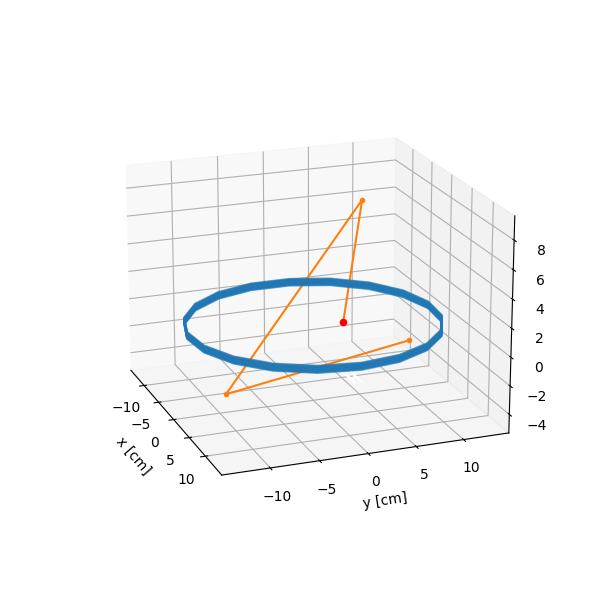

Starting position (x_0,y_0,z_0) = (0.46,3.02,0.17)
step 1: ds=8.72cm dt=290.74ps E=100.00 xy =(0.55,4.95,8.67) u=(0.01,0.22,0.98)
step 2: ds=19.11cm dt=637.51ps E=90.00 xy =(-1.26,-8.91,-4.36) u=(-0.09,-0.73,-0.68)
step 3: ds=19.11cm dt=637.51ps E=81.00 xy =(1.54,9.77,-1.46) u=(0.15,0.98,0.15)
step 4: ds=19.11cm dt=637.51ps E=72.90 xy =(-1.28,-7.24,6.78) u=(-0.15,-0.89,0.43)


In [56]:
# Plot
%matplotlib notebook
fig0 = plt.figure(figsize=(6,6))
ax0 = fig0.add_subplot(111, projection='3d')
# ax0.plot(scint_radius*np.cos(theta_scint), scint_radius*np.sin(theta_scint), 0)
X, Y, Z = data_for_cylinder_along_z(0,0,scint_radius,0.5)
ax0.plot_wireframe(X, Y, Z, alpha=0.5)
r = random.uniform(0,2*np.pi)
maxdist = np.random.random()*scint_radius
random_track = (maxdist*np.cos(r), maxdist*np.sin(r), np.random.random()*scint_width) # x, y
ax0.scatter(random_track[0],random_track[1],random_track[2], color='red', marker='o')
# pmt_window = plt.Rectangle((x,y), length_pmt_window, width_pmt_window, fc='blue', alpha=0.5)
y_plus_l = y+length_pmt_window
x_plus_w = x+width_pmt_window
x_pmt = [x,x_plus_w,x,x_plus_w]
y_pmt = [y,y,y_plus_l,y_plus_l]
z_pmt = [0,0,0,0]
verts = [list(zip(x_pmt,y_pmt,z_pmt))]
ax0.add_collection3d(Poly3DCollection(verts, facecolors='w'))
# plt.show()
# ax0.add_patch(pmt_window)
tracks = scintillator_monte_carlo(random_track, x_pmt=x, E=100, scint_radius=10, N_max=5, dt=0.2)
# ax0.quiver(tracks[:,0],tracks[:,1],tracks[:,2], tracks[:,3], tracks[:,4],tracks[:,5], scale=10)
line = ax0.plot(tracks[:-1,0],tracks[:-1,1],tracks[:-1,2], alpha=1, color='C1', marker='.')
ax0.grid(True)
ax0.set_xlabel('x [cm]')
ax0.set_ylabel('y [cm]')
plt.show()

- Light tube add is very important for shape of scintilator
- T1: 0.5cm, T4:1cm
- find a mean free path and then at each mean calculate the random.poisson(mean) which is the time to the next scintillation
- at the reflection there is a high chance of absorption -> figure out this probability based off of the properties of the scintillator --> fresnel's equation and white paint layer?
- 

### PMT signal making

In [ ]:
# Taken from c code resource
def photoElectrons(photons, QE):
    n = 0.
    for i in range(photons):
        if np.random.random()<QE:
            n+=1
    return n

def meanDynodeElectrons(E):
    E_per_Electron = 20
    return E/E_per_Electron if E >= 0 else 0

def genDynodeElectrons(E_incoming, E):
    mean = E_incoming*meanDynodeElectrons(E)
    return np.random.poisson(mean)

def photontoElectrons(photons, voltages, QE, N):
    e = photoElectrons(photons, QE)
    prevV = 0.
    for dynode in range(N):
        delta_voltage = V[dynode] - prevV
        e += genDynodeElectrons(e, delta_voltage)
        prevV = V[dynode]
    return e

In [ ]:
n_dynodes = 8
V = np.linspace(150,850,n_dynodes)
# V = [150,300,350,600,750,850]
n_incident_photons = 10000
QE = 0.82
pmtSignal = []
for photon in range(n_incident_photons):
    e = photontoElectrons(1, V, QE, n_dynodes)
    if e>1:
        pmtSignal.append(e)

In [ ]:
print("Dynode Voltages =", V)
fig1, ax1 = plt.subplots(figsize=(6,6))
counts1, bins1 = np.histogram(pmtSignal, bins=40)
logbins1 = np.logspace(np.log10(bins1[0]),np.log10(bins1[-1]),len(bins1))
ax1.hist(pmtSignal, bins=100)
ax1.set_title('Simulated PMT Signal')
ax1.set_ylabel('Count')
ax1.set_xlabel('#electrons')
# ax1.set_xscale('log')
# ax1.set_yscale('log')
ax1.grid(True)
plt.show()